# Poisson-Gamma model

See Mohler et al, *Reducing Bias in Estimates for the Law of Crime Concentration* J.Quantitative Criminology, 2019 https://doi.org/10.1007/s10940-019-09404-1

In [323]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [324]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from itrx import Itr
from scipy.stats import gamma, nbinom, poisson

from spatial import (
    get_force_boundary,
    map_to_spatial_unit,
)
from utils import (
    CATEGORIES,
    Month,
    load_crime_data,
    monthgen,
)


In [325]:
FORCE = "West Yorkshire"
LATEST_DATE = Month(2025, 5)
N_MONTHS = 120
rng = np.random.default_rng(19937)
spatial_unit = "GRID"
spatial_params = {"size": 2000.0}

force_boundary = get_force_boundary(FORCE)

filter = {"Crime type": CATEGORIES[1]}

raw_crime_data = load_crime_data(FORCE, Itr(monthgen(LATEST_DATE, backwards=True)).take(N_MONTHS), filters=filter)
raw_crime_data

,Month,Reported by,Falls within,Location,LSOA code,LSOA name,Crime type,geometry
Crime ID,,,,,,,,
None,2025-05,West Yorkshire Police,West Yorkshire Police,On or near Coniston Avenue,E01007363,Barnsley 004E,Anti-social behaviour,POINT (432210.998 410938.045)
None,2025-05,West Yorkshire Police,West Yorkshire Police,On or near Wood Royd Hill Lane,E01007426,Barnsley 027D,Anti-social behaviour,POINT (417790.009 405417.966)
None,2025-05,West Yorkshire Police,West Yorkshire Police,On or near Bus/Coach Station,E01010692,Bradford 001D,Anti-social behaviour,POINT (411838.68 447615.131)
None,2025-05,West Yorkshire Police,West Yorkshire Police,On or near Heather Court,E01010692,Bradford 001D,Anti-social behaviour,POINT (411526.994 447273.002)
None,2025-05,West Yorkshire Police,West Yorkshire Police,On or near Undercliffe Rise,E01010691,Bradford 002A,Anti-social behaviour,POINT (413203.97 446959.981)
...,...,...,...,...,...,...,...,...
None,2015-06,West Yorkshire Police,West Yorkshire Police,On or near Mill Lane,E01011872,Wakefield 045D,Anti-social behaviour,POINT (444489.02 410629.008)
None,2015-06,West Yorkshire Police,West Yorkshire Police,On or near Mill Street,E01011872,Wakefield 045D,Anti-social behaviour,POINT (444425.029 410683.036)
None,2015-06,West Yorkshire Police,West Yorkshire Police,On or near Green Lane,E01011872,Wakefield 045D,Anti-social behaviour,POINT (444591.98 410823.021)


In [338]:
crime_data, features = map_to_spatial_unit(raw_crime_data, force_boundary, spatial_unit, **spatial_params)
features.area.mean() ** 0.5

np.float64(2000.0)

In [ ]:
# ensure we account for crime-free LSOAs in the data
counts = (
    crime_data.groupby(["spatial_unit", "Month"])["Crime type"].count().unstack(level="Month", fill_value=0).sort_index()
)
counts = counts.reindex(features.index, fill_value=0)
# counts.to_csv(f"{spatial_unit}_counts.csv")
counts


Month,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,...,2024-08,2024-09,2024-10,2024-11,2024-12,2025-01,2025-02,2025-03,2025-04,2025-05
38,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,0,0
40,1,1,0,0,1,0,0,1,0,0,...,0,3,1,1,0,0,0,0,0,0
63,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
64,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
873,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
874,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
875,7,6,12,11,15,15,7,14,15,14,...,7,3,1,1,3,3,5,2,7,3
876,0,4,3,2,9,10,6,8,2,1,...,2,1,0,1,0,1,0,0,0,0


In [351]:
def nbinom_fit(sample: pd.Series):
    sample.name = "nbdata"
    # Dispersion parameter from nb model with only interaction term
    nbfit = smf.negativebinomial("nbdata ~ 1", data=sample.to_frame()).fit()
    mu = np.exp(nbfit.params[0])  # Intercept (log(mu))
    alpha = nbfit.params[1]  # Dispersion parameter
    var = mu + alpha * mu**2
    p = mu / var
    n = mu**2 / (var - mu)
    return pd.Series({"n": n, "p": p, "mu": mu})

In [352]:
model_params = counts.apply(nbinom_fit).T
model_params

Optimization terminated successfully.
         Current function value: 2.986956
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 3.040846
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 3.034559
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 2.949344
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 2.966773
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 2.849189
         Iterations: 6
         Function evaluations: 8
         Gradient e

/tmp/ipykernel_7695/824935512.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])  # Intercept (log(mu))
/tmp/ipykernel_7695/824935512.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_7695/824935512.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])  # Intercept (log(mu))
/tmp/ipykernel_7695/824935512.py:6: Fu

Optimization terminated successfully.
         Current function value: 2.548921
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 2.569014
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 2.422178
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 2.195152
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 2.345297
         Iterations: 4
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 2.271283
         Iterations: 4
         Function evaluations: 7
         Gradient e

/tmp/ipykernel_7695/824935512.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])  # Intercept (log(mu))
/tmp/ipykernel_7695/824935512.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_7695/824935512.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])  # Intercept (log(mu))
/tmp/ipykernel_7695/824935512.py:6: Fu

Optimization terminated successfully.
         Current function value: 2.361729
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 2.310026
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 2.094560
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 2.292470
         Iterations: 6
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 2.168645
         Iterations: 5
         Function evaluations: 7
         Gradient evaluations: 7
Optimization terminated successfully.
         Current function value: 1.891028
         Iterations: 5
         Function evaluations: 8
         Gradient e

/tmp/ipykernel_7695/824935512.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])  # Intercept (log(mu))
/tmp/ipykernel_7695/824935512.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  alpha = nbfit.params[1]  # Dispersion parameter
/tmp/ipykernel_7695/824935512.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mu = np.exp(nbfit.params[0])  # Intercept (log(mu))
/tmp/ipykernel_7695/824935512.py:6: Fu

,n,p,mu
Month,,,
2015-06,0.268616,0.023995,10.925990
2015-07,0.271359,0.023021,11.516351
2015-08,0.261588,0.021755,11.762478
2015-09,0.287717,0.028118,9.944923
2015-10,0.250824,0.021680,11.318417
...,...,...,...
2025-01,0.247429,0.083786,2.705680
2025-02,0.236897,0.088250,2.447504
2025-03,0.272384,0.066043,3.851979


<Axes: xlabel='Month'>

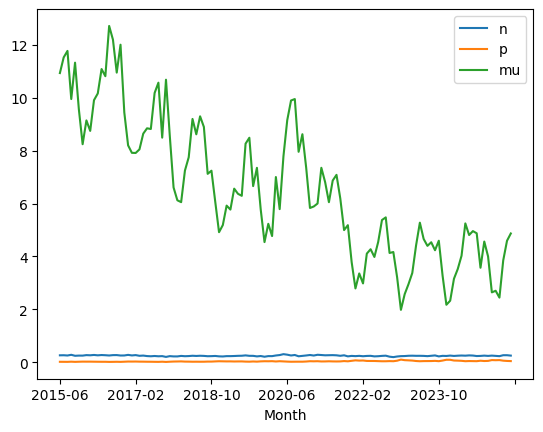

In [353]:
model_params.plot()

<Axes: xlabel='2025-05'>

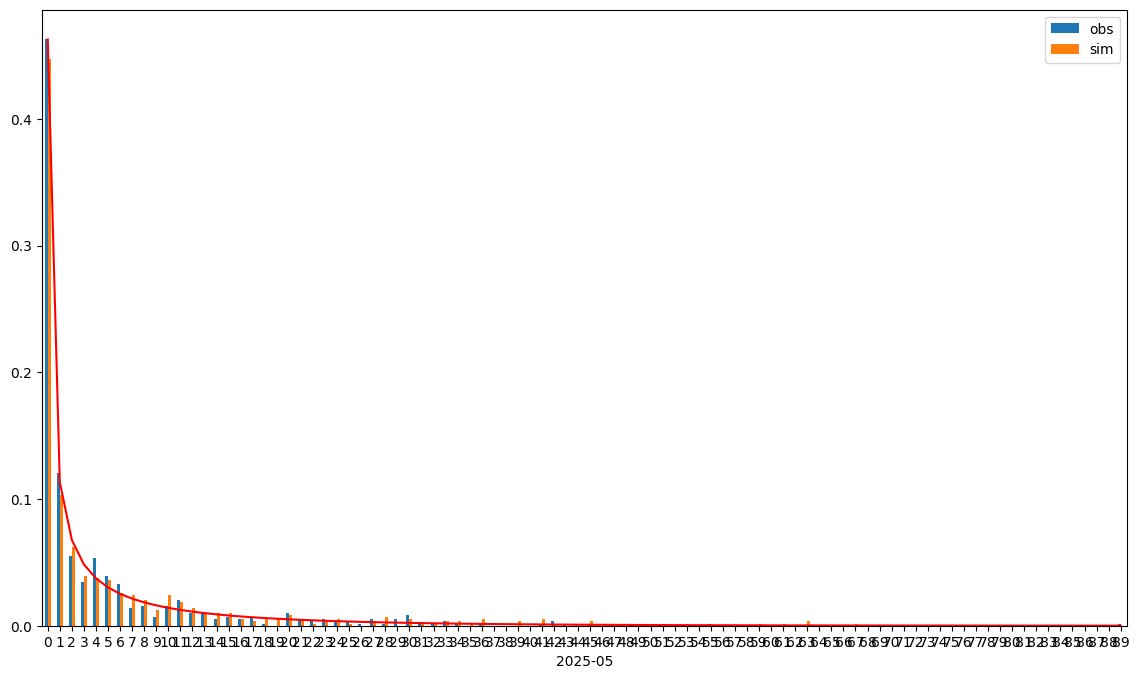

In [354]:
# sanity-check the neg binomial params

m = str(LATEST_DATE)
n, p, mu = model_params.loc[m]

nb_dist = nbinom(n, p)
nb_sample = nb_dist.rvs(len(features))

df = counts[m].value_counts().rename("obs").reindex(range(counts[m].max()+1)).to_frame()
#df = df.join(np.unique(nb_sample.)
df = df.join(pd.Series(*np.unique(nb_sample, return_counts=True)[::-1], name="sim"))
df["nbinom"] = nb_dist.pmf(df.index)

# normalise
df.obs = df.obs / df.obs.sum()
df.sim = df.sim / df.sim.sum()

ax = df[["obs", "sim"]].plot.bar(figsize=(14, 8))
df["nbinom"].plot(ax=ax, c="r")
#ax.set_xlim(0, 20)

In [355]:
errors = pd.Series(index=model_params.index)

for m, n, p, mu in model_params.itertuples():
    nb_sample = nbinom(n, p).rvs(len(features))
    errors.loc[m] = counts[m].sum() / nb_sample.sum() - 1.0
errors.mean(), np.sqrt((errors ** 2).mean())


(np.float64(0.0006000779241120866), np.float64(0.08951194881521234))

In [356]:
len(counts)

581

obs    2829
sim    3036
dtype: int64

2829.0

<Axes: >

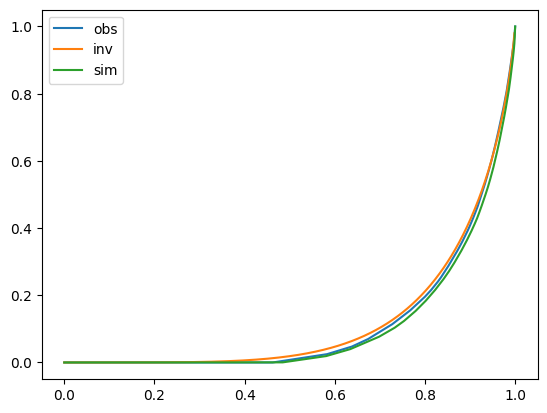

In [382]:
# now sample Poisson lambdas from the gamma dist from one month and compare with actual...
N = len(features)

compare = pd.DataFrame(index=np.linspace(0, 1, N), data={"obs": np.sort(counts[str(LATEST_DATE)])})

# construct the distribution
n, _, mu = model_params.loc[str(LATEST_DATE)]
gamma_dist = gamma(a=n, scale=mu/n)

# compute the inverse cdf
compare["inv"] = gamma_dist.ppf(q=compare.index)

# sample Poisson lambdas
lambdas = gamma_dist.rvs(N)
# now sample each Poisson
compare["sim"] = np.sort(poisson(lambdas).rvs(len(lambdas)))

# show the totals
display(compare[["obs", "sim"]].sum(), mu * N)

compare.obs = compare.obs.cumsum() / compare.obs.sum()
# fix the inf at x=1 (the integral of the inverse CDF between 0 and 1 is the mean: mu * N
compare.inv = compare.inv.cumsum() / (mu * N)
compare.sim = compare.sim.cumsum() / compare.sim.sum()

compare.plot()

#plt.plot(compare.actual, compare.sampled)
